# Analyze Layout Sticking in LayoutDM

In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/app


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from __future__ import annotations

import copy
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import torch

from einops import rearrange, reduce, repeat
import scienceplots

from trainer.models.categorical_diffusion.util import alpha_schedule

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# define plot style
plt.style.use(['science','no-latex', 'grid'])
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Utility

In [4]:
def to_tensor(ids, decoded_ids):
    tensor_ids = torch.Tensor(ids).long()
    tensor_decoded_ids = [
        dict(
            bbox=torch.Tensor(_dec_ids["bbox"]).long(),
            label=torch.Tensor(_dec_ids["label"]).long(),
            mask=torch.Tensor(_dec_ids["mask"]).bool(),
        )
        for _dec_ids in decoded_ids 
    ]
    return tensor_ids, tensor_decoded_ids


def calc_token_sticking_rate(
    ids: list[torch.Tensor],
    pad_id: int,
    mask_id: int,
) -> list[float]:
    """Calculate token sticking rate between x_0 and x_t
    
    The results are average of batch samples.
    MASK tokens are ignored and optionally PAD tokens are too.
    """
    num_timesteps = len(ids)
    token_sticking_rates = list()
    x_0 = ids[-1]
    for t in range(num_timesteps):
        x_t = ids[t]  # (B, num_attributes * num_max_elements)
        mask_idx = x_t == mask_id
        pad_idx = x_t == pad_id
        invalid_idx = torch.logical_or(mask_idx, pad_idx)
        num_valid_idx = (~invalid_idx).sum()

        match_idx = x_t == x_0
        match_idx[invalid_idx] = False
        token_sticking_rate = (match_idx.sum() / num_valid_idx).cpu().item() if num_valid_idx > 0 else 0.0
        token_sticking_rates.append(token_sticking_rate)

    token_sticking_rates = 100 * np.array(token_sticking_rates)
    return token_sticking_rates


def calc_elem_sticking_rate(
    ids: list[torch.Tensor],
    pad_id: int,
    mask_id: int,
    num_attributes: int = 5,
) -> list[float]:
    """Calculate element sticking rate between x_0 and x_t
    
    The results are average of batch samples.
    If an element includes a MASK token, the corresponding element is ignored.
    We focus on completly generated elements only.
    """
    num_timesteps = len(ids)
    elem_sticking_rates = list()
    
    # e = num_tokens_in_elem, s = num_elements
    assert ids[-1].shape[-1] % num_attributes == 0 
    x_0 = rearrange(ids[-1], "b (e s) -> b e s", e=num_attributes)
    for t in range(num_timesteps):
        x_t = rearrange(ids[t], "b (e s) -> b e s", e=num_attributes)
        # If there is at least one MASK token in an element, we do not count that element.
        elem_mask_seq = (x_t == mask_id).any(dim=1)  # (b, s)
        elem_pad_seq = (x_t == pad_id).any(dim=1)
        invalid_elem_seq = torch.logical_or(elem_mask_seq, elem_pad_seq)
        B, S = invalid_elem_seq.shape[0], invalid_elem_seq.shape[1]
        num_valid_seq = (~invalid_elem_seq).sum()

        token_match_idx = x_t == x_0
        invalid_token_idx = repeat(invalid_elem_seq, "b s -> b e s", e=num_attributes)
        token_match_idx[invalid_token_idx] = False
        elem_match_idx = token_match_idx.all(dim=1)
        
        elem_sticking_rate = (elem_match_idx.sum() / num_valid_seq).cpu().item() if num_valid_seq > 0 else 0.0
        elem_sticking_rates.append(elem_sticking_rate)

    elem_sticking_rates = 100 * np.array(elem_sticking_rates)
    return elem_sticking_rates


def calc_mask_rate(
    ids: list[torch.Tensor],
    mask_id: int,
) -> list[float]:
    """Calculate mask rate on each timestep
    
    The results are average of batch samples.
    """
    num_timesteps = len(ids)
    mask_rates = list()
    for t in range(num_timesteps):
        x_t = ids[t]  # (B, num_attributes * num_max_elements)
        mask_idx = x_t == mask_id
        num_mask_tokens = mask_idx.sum()
        num_all_tokens = x_t.shape[0] * x_t.shape[1]
        mask_rates.append(num_mask_tokens / num_all_tokens)

    mask_rates = 100 * np.array(mask_rates)
    return mask_rates


def calc_transition_rates(
    ids: list[torch.Tensor],
    mask_id: int,
    pad_id: int | None = None
) -> tuple[list[float], list[float]]:
    """Calculate transition rates
    
    We calculate two transition rates
    - between x_t and x_0
    - between x_t and x_{t-1} (adjacent timesteps)

    Returns:
        xt2x0_transition_rates (list[float]): Transition rates between x_t and x_0
        xt2x_1_transition_rates (list[float]): Transition rates between x_t and x_{t-1}
    """
    xt2x0_transition_rates = []    # x_t to x_0 token transition rate
    xt2xt_1_transition_rates = []  # x_t to x_{t-1} token transition rate
    x0_ids = ids[-1]
    num_timesteps = len(ids)
    for timestep in range(num_timesteps):
        not_mask_token = ids[timestep] != mask_id
        valid_token_on_xt = not_mask_token
        if pad_id is not None:
            not_pad_token = ids[timestep] != pad_id
            valid_token_on_xt = torch.logical_and(valid_token_on_xt, not_pad_token)
        num_valid_tokens_on_xt = valid_token_on_xt.long().sum()

        # x_t to x_0
        num_moved_tokens_to_x0 = (ids[timestep] != x0_ids)[valid_token_on_xt].long().sum()
        xt2x0_transition_rate = num_moved_tokens_to_x0 / num_valid_tokens_on_xt if num_valid_tokens_on_xt != 0 else torch.zeros(1)
        xt2x0_transition_rates.append(xt2x0_transition_rate.item())

        # x_t to x_{t-1}
        if timestep + 1 < num_timesteps:
            num_moved_tokens_to_xt_1 = (ids[timestep] != ids[timestep + 1])[valid_token_on_xt].long().sum()
            xt2xt_1_transition_rate = num_moved_tokens_to_xt_1 / num_valid_tokens_on_xt if num_valid_tokens_on_xt != 0 else torch.zeros(1)
            xt2xt_1_transition_rates.append(xt2xt_1_transition_rate.item())

    return xt2x0_transition_rates, xt2xt_1_transition_rates

## Data Preparation

In [5]:
!python tools/visualize_generation_process.py download/pretrained_weights/rico25/layoutdm/0/ --num_samples 100 --save_dir ./layoutdm_rico25/beta00to00

## Configs

In [6]:
# NOTE: For full reproduction, please train LayoutDM using `src/trainer/trainer/config/model/layoutdm_custom_Q.yaml` to align with the following schedules.
# Load outputs of tools/visualize_generation_process.py
ROOT = "./layoutdm_rico25"
key2pickle = dict(
    beta_00to00=f"{ROOT}/beta00to00/generation_process_output.pickle",
    # beta_00to005=f"{ROOT}/beta00to005/generation_process_output.pickle",
    # beta_00to010=f"{ROOT}/beta00to01/generation_process_output.pickle",
    # beta_005to00=f"{ROOT}/beta005to00/generation_process_output.pickle",
    # beta_010to00=f"{ROOT}/beta01to00/generation_process_output.pickle",
)

# transition schedule
N = 153  # Rico: 32bins x 4(xywh) + 25classes = 153
num_timesteps = 100  # LayoutDM default
key2schedule = dict(
    beta_00to00=dict(num_timesteps=num_timesteps, N=N, att_1=0.99999, att_T=0.000009, ctt_1=0.000009, ctt_T=0.99999),
    beta_00to005=dict(num_timesteps=num_timesteps, N=N, att_1=0.99999, att_T=0.000009, ctt_1=0.000009, ctt_T=0.95),
    beta_00to010=dict(num_timesteps=num_timesteps, N=N, att_1=0.99999, att_T=0.000009, ctt_1=0.000009, ctt_T=0.9),
    beta_005to00=dict(num_timesteps=num_timesteps, N=N, att_1=0.95, att_T=0.000009, ctt_1=0.000009, ctt_T=0.99999),
    beta_010to00=dict(num_timesteps=num_timesteps, N=N, att_1=0.9, att_T=0.000009, ctt_1=0.000009, ctt_T=0.99999),
)

# for legend
key2label = dict(
    beta_00to00=r"$\epsilon \rightarrow \epsilon$",
    beta_00to005=r"$\epsilon \rightarrow 0.05$",
    beta_00to010=r"$\epsilon \rightarrow 0.1$",
    beta_005to00=r"$0.05 \rightarrow \epsilon$",
    beta_010to00=r"$0.1 \rightarrow \epsilon$",
)


## Load data

In [7]:
key2data = dict()

for key, path in key2pickle.items():
    with open(path, "rb") as f:
        data = pickle.load(f)
        key2data[key] = data
        
# extract constants
first_key = list(key2data.keys())[0]
first_data = key2data[first_key]

PAD_ID = first_data["pad_id"]
MASK_ID = first_data["mask_id"]
NUM_ATTRIBUTES = first_data["num_attributes"]

## Calculate sticking and masking rate

In [8]:
key2ids = dict()
corrector_key2ids = dict()

for key, data in key2data.items():
    orig_ids = data["original_ids"]
    orig_decoded_ids = data["original_decoded_ids"]
    corr_ids = data.get("corrector_ids")
    corr_decoded_ids = data.get("corrector_decoded_ids")
    
    # list to tensor
    orig_ids, orig_decoded_ids = to_tensor(orig_ids, orig_decoded_ids)
    key2ids[key] = orig_ids
    
    if corr_ids is not None:
        corr_ids, corr_decoded_ids = to_tensor(corr_ids, corr_decoded_ids)
        corrector_key2ids[key] = corr_ids

In [9]:
# Vocabulary
# tsr: token sticking rate
# esr: element sticking rate
# mr: mask rate

orig_key2tsr = {
    key: calc_token_sticking_rate(ids, PAD_ID, MASK_ID)
    for key, ids in key2ids.items()
}

orig_key2esr = {
    key: calc_elem_sticking_rate(ids, PAD_ID, MASK_ID, num_attributes=NUM_ATTRIBUTES)
    for key, ids in key2ids.items()
}

orig_key2mr = {
    key: calc_mask_rate(ids, MASK_ID)
    for key, ids in key2ids.items()
}

## Beta schedule + Token Sticking Rate

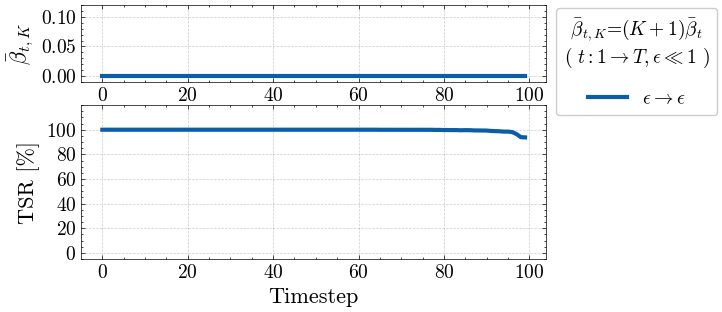

In [10]:
h, w = 3.3, 6  # 4, 6
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(w, h), gridspec_kw=dict(height_ratios=[1, 2]))  # (nrow, ncol)

legend_title = r"$\bar{\beta}_{t,K}$=$(K+1)\bar{\beta}_t$" + "\n" + r"$(~t: 1 \rightarrow T, \epsilon \ll 1~)$"

ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)
ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)
for i, key in enumerate(key2pickle.keys()):
    color = color_list[i]

    # beta schedule
    sch_params = key2schedule[key]
    at, bt, ct, att, btt, ctt = alpha_schedule(**sch_params)
    num_timesteps = sch_params["num_timesteps"]
    n_classes = sch_params["N"]
    net_btt = n_classes * btt
    ax1.plot(net_btt[:num_timesteps], color=color, linewidth=3, label=key2label[key])

    # sticking rate
    sticking_rates = orig_key2tsr[key]
    timestep_axis = np.arange(len(sticking_rates))[::-1]  # flip to align the generation process
    ax2.plot(timestep_axis, sticking_rates, color=color, linewidth=3)

# ax1.set_xlabel("Timestep", fontsize=16)
ax1.set_ylabel(r"$\bar{\beta}_{t,K}$", fontsize=16)
ax1.set_xticks(np.arange(0, 102, 20))
ax1.set_yticks(np.arange(0, 0.2, 0.05))
ax1.set_ylim(-0.01, 0.12)
ax1.grid(visible=True, alpha=0.2)

ax2.set_xlabel("Timestep", fontsize=16)
ax2.set_ylabel("TSR [%]", fontsize=16)  # TSR: Token Sticking Rate
ax2.set_xticks(np.arange(0, 102, 20))
ax2.set_yticks(np.arange(0, 120, 20))
ax2.set_ylim(-5, 120)
ax2.grid(visible=True, alpha=0.2)
legend_title = " " + legend_title  # hack to locate center
fig.legend(title=legend_title, loc="upper left", bbox_to_anchor=(0.9, 0.9), labelspacing=1.0, fontsize=14, title_fontsize=14)  # not work on matplotlib==3.5.2

plt.savefig(os.path.join(ROOT, f"pre_exp_a_h{h}w{w}.pdf"))
plt.show()

## Comparison of transition schedules

beta_00to00


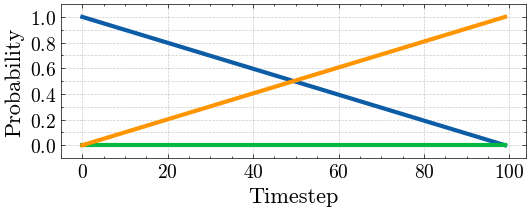

beta_00to005


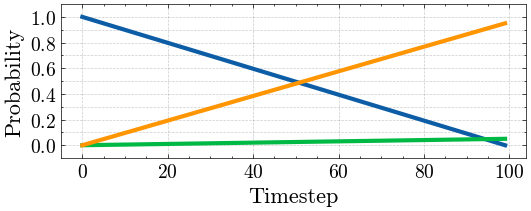

beta_00to010


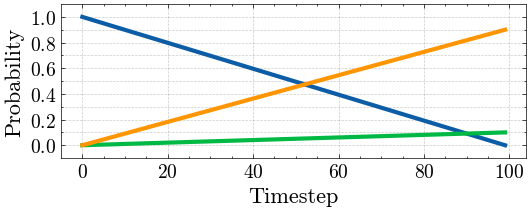

beta_005to00


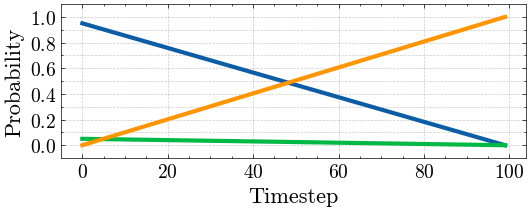

beta_010to00


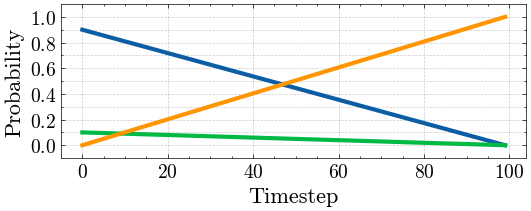

In [11]:
from matplotlib.ticker import FixedLocator


h, w = 2, 6
for i, key in enumerate(key2label.keys()):
    fig, ax = plt.subplots(1, 1, figsize=(w, h))  # (nrow, ncol)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)

    sch_params = key2schedule[key]
    at, bt, ct, att, btt, ctt = alpha_schedule(**sch_params)
    num_timesteps = sch_params["num_timesteps"]
    n_classes = sch_params["N"]
    # alpha, beta, gamma
    ax.plot(att[:num_timesteps], color=color_list[0], linewidth=3, label=r"$\bar{\alpha}_t$")
    net_btt = n_classes * btt
    ax.plot(net_btt[:num_timesteps], color=color_list[1], linewidth=3, label=r"$\bar{\beta}_{t,K}$")
    ax.plot(ctt[:num_timesteps], color=color_list[2], linewidth=3, label=r"$\bar{\gamma}_t$")
 
    ax.set_ylabel("Probability", fontsize=16)
    ax.set_xticks(np.arange(0, 102, 20))
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    ax.yaxis.set_minor_locator(FixedLocator(np.arange(0.1, 1.1, 0.1)))
    ax.set_ylim(-0.1, 1.1)
    ax.grid(which="major", visible=True, alpha=0.2)
    ax.grid(which="minor", axis="y", visible=True, alpha=0.2)
    ax.set_xlabel("Timestep", fontsize=16)
    if key == "beta_0to0":
        fig.legend(loc="lower center", labelspacing=0.5, fontsize=14, title_fontsize=14, ncol=3, bbox_to_anchor=(0.5, 0.88))
    plt.savefig(os.path.join(ROOT, f"full_schedule_{key}_h{h}w{w}.pdf"))
    print(key)
    plt.show()
    plt.close()
